# Import libraries and load the data


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import fbprophet
import statsmodels.tsa.stattools as sm
import generate_time_series as gts

print("Successfully loaded libraries")

In [4]:
print(os.getcwd())

/Users/maximus/Desktop/btsa/python/prophet_test


In [20]:
# Load the sample data
sample_data = pd.read_csv("../../data/sample_data_1.csv")
#  Rename columns to prophet format
sample_data.columns = ['ds','media','y']
#  Convert the date object to datetime
sample_data['ds'] = pd.to_datetime(sample_data['ds'])

In [22]:
sample_data

,ds,media,y
0,2018-01-03,0.000000,6.258472
1,2018-01-04,0.000000,6.170889
2,2018-01-05,0.000000,5.754669
3,2018-01-06,0.000000,5.968413
4,2018-01-07,0.000000,5.285262
...,...,...,...
1362,2021-09-26,0.000000,NaN
1363,2021-09-27,0.000000,NaN
1364,2021-09-28,0.000000,NaN
1365,2021-09-29,0.909033,NaN


In [23]:
# Add a media variable at lag 1 and 2
sample_data['media_lag_1'] = sample_data['media'].shift(1)
sample_data['media_lag_2'] = sample_data['media'].shift(2)

# Add a 31 day lag variable
sample_data['y_lag_31'] = sample_data['y'].shift(31)

In [24]:
sample_data.head()

,ds,media,y,media_lag_1,media_lag_2,y_lag_31
0,2018-01-03,0.0,6.258472,NaN,NaN,NaN
1,2018-01-04,0.0,6.170889,0.0,NaN,NaN
2,2018-01-05,0.0,5.754669,0.0,0.0,NaN
3,2018-01-06,0.0,5.968413,0.0,0.0,NaN
4,2018-01-07,0.0,5.285262,0.0,0.0,NaN


In [25]:
# Fill NA values with zeroes
sample_data.loc[0,'media_lag_1'] = 0
sample_data.loc[0:1,'media_lag_2'] = 0

# Fill the y_lag_31 values with the first genuine data point
sample_data.loc[0:30,'y_lag_31'] = 6.258472

# Add a 7th of July dummy to account for the negative spike
sample_data['seven_seven'] = sample_data['ds'].isin(["2018-07-07","2019-07-07","2020-07-07","2021-07-07"])
sample_data['seven_seven'] = sample_data['seven_seven'].astype(int)

In [26]:
# Add the structure break variable to the dataset
struct_break = np.where(sample_data['ds'] ==  "2020-01-31")
struct_break = np.concatenate([np.repeat(0, struct_break[-1]), np.repeat(1, sample_data.shape[0] - struct_break[-1])])
sample_data['struct_break'] = struct_break

In [27]:
# Split into training and test sets
train_indices = np.where(~(sample_data['y'].isnull()))[-1]
test_indices = np.where(sample_data['y'].isnull())[-1]

train = sample_data.iloc[train_indices,:]
test = sample_data.iloc[test_indices,:]

# Drop the na values from the lagged terms
train = train.dropna()

In [28]:
sample_data

,ds,media,y,media_lag_1,media_lag_2,y_lag_31,seven_seven,struct_break
0,2018-01-03,0.000000,6.258472,0.000000,0.0,6.258472,0,0
1,2018-01-04,0.000000,6.170889,0.000000,0.0,6.258472,0,0
2,2018-01-05,0.000000,5.754669,0.000000,0.0,6.258472,0,0
3,2018-01-06,0.000000,5.968413,0.000000,0.0,6.258472,0,0
4,2018-01-07,0.000000,5.285262,0.000000,0.0,6.258472,0,0
...,...,...,...,...,...,...,...,...
1362,2021-09-26,0.000000,NaN,0.000000,0.0,NaN,0,1
1363,2021-09-27,0.000000,NaN,0.000000,0.0,NaN,0,1
1364,2021-09-28,0.000000,NaN,0.000000,0.0,NaN,0,1
1365,2021-09-29,0.909033,NaN,0.000000,0.0,NaN,0,1


#Exploratory Analysis:

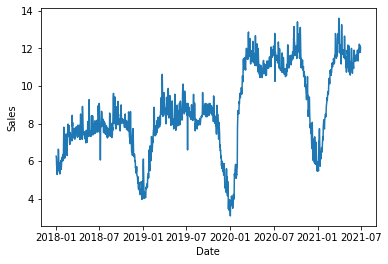

In [29]:
# Plot the sample Sales over time

plt.plot(sample_data['ds'],sample_data['y'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


-Notice an increasing trend (maybe linear)

-Possibly some seasonal patterns

-Something weird going on around January 2020

-Increasing variance?

In [36]:
train.head()

,ds,media,y,media_lag_1,media_lag_2,y_lag_31,seven_seven,struct_break
0,2018-01-03,0.0,6.258472,0.0,0.0,6.258472,0,0
1,2018-01-04,0.0,6.170889,0.0,0.0,6.258472,0,0
2,2018-01-05,0.0,5.754669,0.0,0.0,6.258472,0,0
3,2018-01-06,0.0,5.968413,0.0,0.0,6.258472,0,0
4,2018-01-07,0.0,5.285262,0.0,0.0,6.258472,0,0


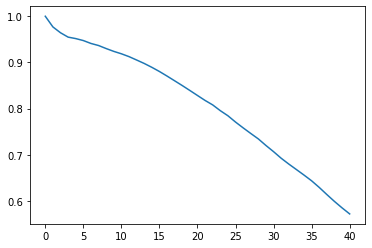

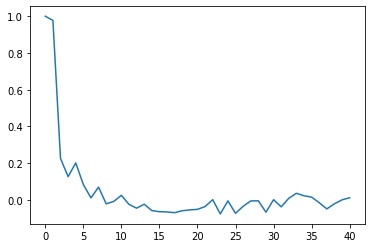

In [33]:
# ACF - Clearly autocorrelation
acf_values = sm.acf(train['y'])
plt.plot(acf_values)
plt.show()
# PACF
acf_values = sm.pacf(train['y'])
plt.plot(acf_values)
plt.show()

- Autocorrelated, but its obvious if you look at the strong trend and seasonality in the time series

In [35]:
# Check cross correlation between the media variable and the time series
sm.ccf(train['media'], train['y'])
# In conclusive because of the presense of the trend. Need to check the cross correlation later on a stationary remainder component.

array([ 0.12633702, -0.00173546, -0.00139267, ...,  0.39809008,
        0.37498521,  0.36838676])

# Facebook Prophet Models

- Start with the out-of-the-box Facebook Prophet Model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


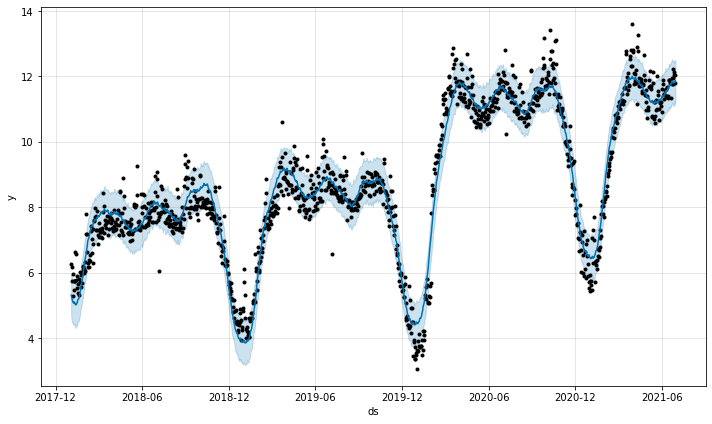

In [42]:
# Start with a default prophet model
prophet_model = fbprophet.Prophet()
prophet_model.fit(train)


future = prophet_model.make_future_dataframe(periods=60)
future.tail()

# Check the fit
fit = prophet_model.predict(train)

# Plot the forecast
fit_plot = prophet_model.plot(fit)
fit_plot.show()

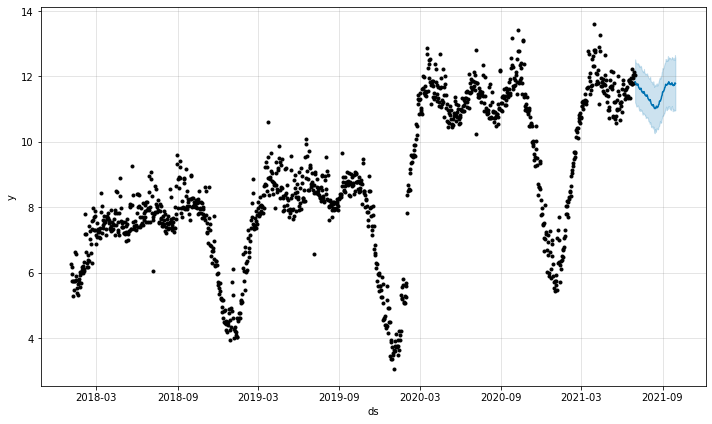

In [43]:
y_f =  prophet_model.predict(test)
forecast_plot = prophet_model.plot(y_f)
forecast_plot.show()

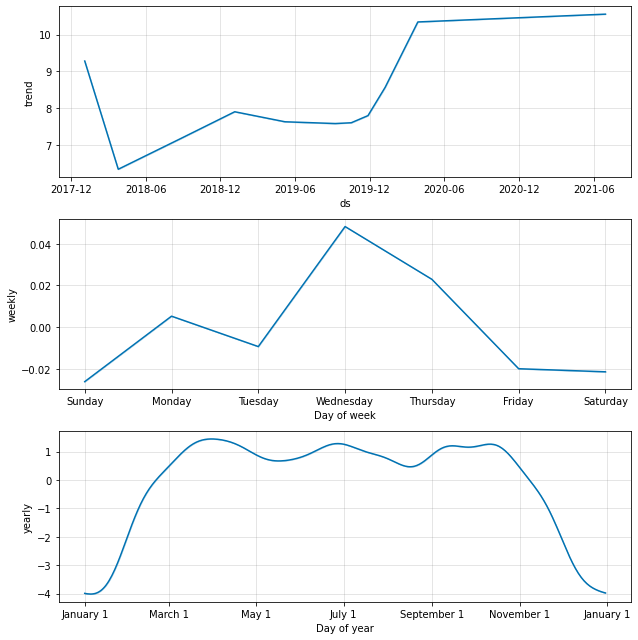

In [44]:
# Plot the fit components
comp_plot = prophet_model.plot_components(fit)
comp_plot.show()

- Trend has an unusual pattern. This is probably an overfit, and also indicating that something is missing
- Is weekly seasonality an overfit? One term for each weekday and very low coefficients suggests that we dont need it
- Yearly seasonality looks ok

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


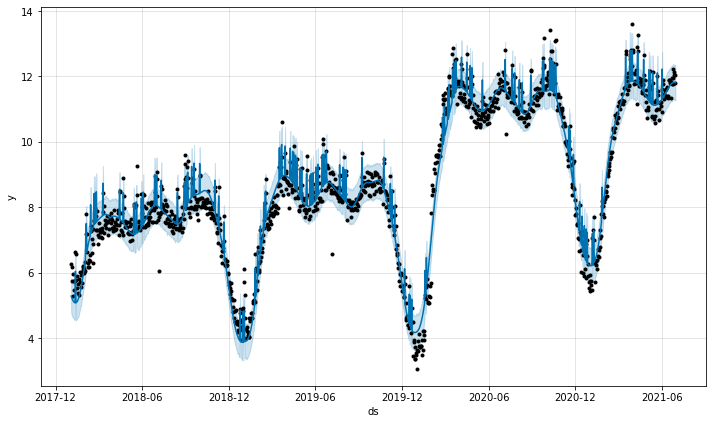

In [46]:
# Add the external regressor (Media) and retrain. Disable weekly seasonality.
prophet_model = fbprophet.Prophet(weekly_seasonality=False)
prophet_model.add_regressor("media")
prophet_model.fit(train)

fit_x = prophet_model.predict(train)

# Plot the new fit
fit_plot = prophet_model.plot(fit_x)
fit_plot.show()



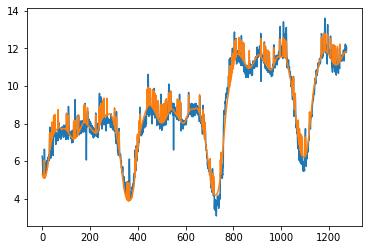

In [47]:
plt.plot(train['y'])
plt.plot(fit_x['yhat'])
plt.show()

### Something is still a bit off at Jan 2020. Lets look at how the changepoint detection works

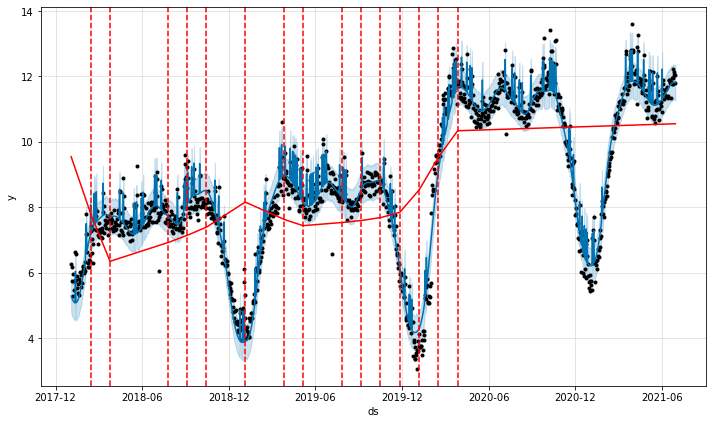

In [49]:
# Lets look  at the changepoint detection
fit_plot = prophet_model.plot(fit_x)
a = fbprophet.plot.add_changepoints_to_plot(fit_plot.gca(), prophet_model, fit_x)
fit_plot.show()

In [ ]:
- This plot shows that Prophet is detecting a linaer structure after 2020-01
- But we have an unusual combination of piecewise linear terms at the start, suggesting an overfit
- Probably missing a multiplicative effect and some additional structure
- Now lets look at the residuals to double check

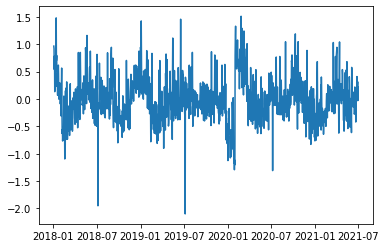

In [50]:
res = train['y'] - fit_x['yhat']
plt.plot(train['ds'], res)
plt.show()

In [55]:
sm.ccf(train['media'], res)

array([ 2.02998843e-05, -1.50135065e-02,  2.59854512e-03, ...,
       -6.63145739e-01, -7.73271773e-01, -7.92582104e-01])

- Definitely some structural break at Jan 2020
- Also, I didnt spot this before, but we can clearly see an important effect in July, 2018, 2019, 2020

# Next model:
 - Add a dummy variable for the 07/07
 - Add multiplicative seasonality to account for increasing variance over time
 - Add a single changepoint, and linear trend otherwise
 - Add media lag 1

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


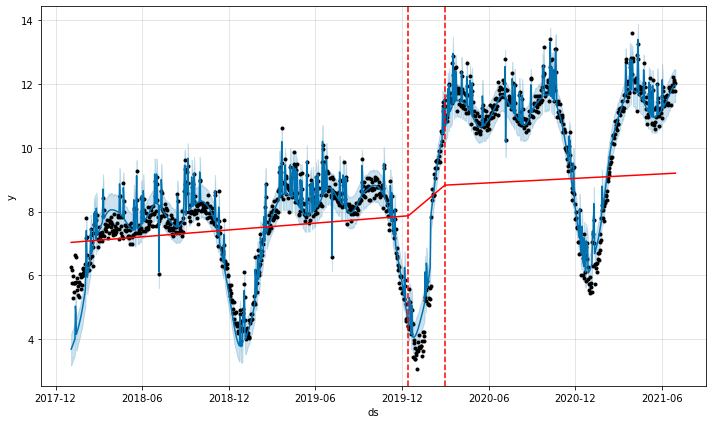

In [56]:
prophet_model = fbprophet.Prophet(changepoints=["2019-12-15","2020-03-01"], weekly_seasonality=False)
prophet_model.add_seasonality("yearly", period=365.25, fourier_order=12, mode="multiplicative")
prophet_model.add_regressor("struct_break")
prophet_model.add_regressor("media")
prophet_model.add_regressor("media_lag_1")
prophet_model.add_regressor("seven_seven")
fit_xc = prophet_model.fit(train)

fit_xc = fit_xc.predict(train)
fit_plot = prophet_model.plot(fit_xc)
a = fbprophet.plot.add_changepoints_to_plot(fit_plot.gca(), prophet_model, fit_xc)
fit_plot.show()

- The model is still not really picking up the changepoint as I'd hoped
- The multiplicative effect is still not modelled exactly as I'd hoped. This is indicated by the large error at the beginning of the series
- I played around with the "multiplicative" seasonality option, manual and automatic changepoints, but I didnt 100% get the model fit I wanted. This could be due to a lack of experience with the tool.

In [ ]:
# Detour to show a comparison with GAM model

#Prophet default on an AR type time series

- Prophet trends the trend as a completely deterministic (but unexplained) piecewise linear function.
- This would appear to be suitable for the situation where the majority of the variation is caused by external regressors
- Consider the structure of the time series, if there is autocorrelation you might need to add lagged regressors.

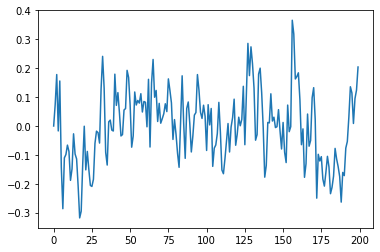

In [58]:

y_arima = gts.generate_arima_walk(1, 200, alpha=0.6)

plt.plot(y_arima)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


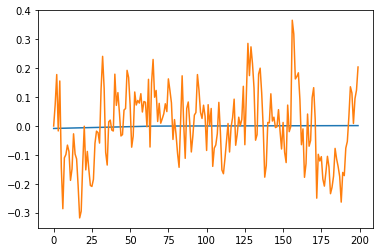

In [61]:
ds = np.arange(1, y_arima.shape[0] + 1)
df = pd.concat([pd.Series(y_arima), pd.Series(ds)], axis=1)
df.columns = ['y','ds']

df['ds'] = pd.to_datetime(df['ds'])
df['y_1'] = df['y'].shift(1)
df['y_1'][0] = 0

arima_model = fbprophet.Prophet()
arima_model.fit(df)

forecast = arima_model.predict(df)

plt.plot(forecast['yhat'])
plt.plot(df['y'])
plt.show()


- Add an autocorrelation feature in order to account for the trend

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


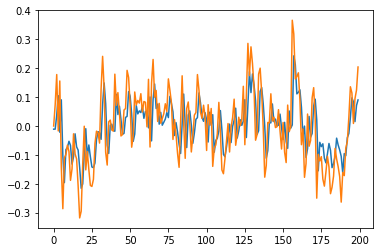

In [62]:
arima_model = fbprophet.Prophet()
arima_model.add_regressor('y_1')
arima_model.fit(df)

forecast = arima_model.predict(df)

plt.plot(forecast['yhat'])
plt.plot(df['y'])
plt.show()